# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import os
#Configurazione di cuda
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


In [2]:
import torch
import torchvision
import os
from torchvision.datasets import FakeData
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch import optim
import numpy as np
from sklearn import metrics
import random


In [3]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True


In [4]:
torch.cuda.is_available()

True

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers= True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)
fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


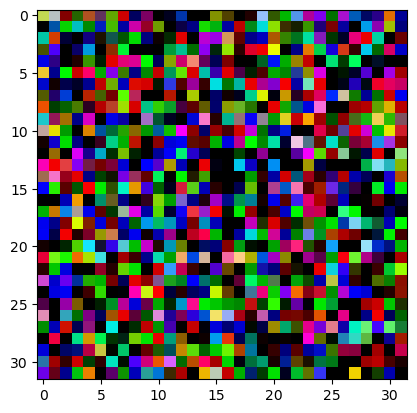

In [6]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    break

x.shape, trainset.classes[y[0]]

trainset.classes
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)} 

Questa immagine rappresenta un perfetto esempio di OOD (Out-of-Distribution):
- Non assomiglia a nessuna classe CIFAR-10
- È puro rumore

In [7]:
trainset.classes[y[0]]

'horse'

il modello classifica cavallo un'immagine che è puro rumore

In [8]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample
        
        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


In [11]:
device

'cuda'

In [12]:
load_resnet = False
load = False
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            
            yp = model(x)
            l = loss(yp, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(e, running_loss/len(trainloader))
    torch.save(model.state_dict(), f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth')      

0 1.8073102946171675
1 1.4489166340254762
2 1.3019958329017816
3 1.19893649456751
4 1.1223577674087661
5 1.041740488365788
6 0.9605542057005646
7 0.8839893261794849
8 0.8047899503232269
9 0.724393935459654
10 0.6408013678572672
11 0.550146472652245
12 0.4579537034492054
13 0.3637302626886636
14 0.27892771351825246
15 0.2027089300439181
16 0.14499342136675744
17 0.11896210438226495
18 0.0833804594243274
19 0.06433037844012536
20 0.06671156864756209
21 0.061275311736175626
22 0.04442688317188179
23 0.03915243159831904
24 0.05562284874046207
25 0.04142679858004765
26 0.03235891296187668
27 0.03570496606285615
28 0.03637307280581683
29 0.038011384787885925
30 0.03907370992431231
31 0.023330824739059144
32 0.03285998995880337
33 0.027283921239056798
34 0.03633907928710322
35 0.02349782771046233
36 0.027129697342179335
37 0.028301573061185373
38 0.023480658708682135
39 0.017562852774644293
40 0.023326807606714014
41 0.030698671686442813
42 0.02264839646679199
43 0.021855342472234116
44 0.021

Output: loss per ogni epoca (50 epoche totali).

Epoca 0: Loss = 1.81 → Modello "confuso", prestazioni scarse
Epoca 49: Loss = 0.015 → Modello ben addestrato, il modello sta imparando a classificare CIFAR-10

Si ha quindi un modello ben addestrato su CIFAR-10.

Si passa ora a valutare le prestazioni di questo modello.

In [13]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load:
    model = CNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))

In [14]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.

if load_resnet:
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    model.eval()
    model.cuda()
    

In [15]:
#here we test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)
        

Accuracy: 0.6162999868392944


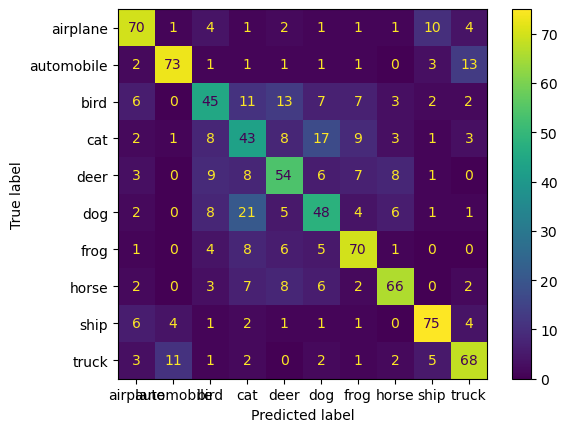

In [16]:
#Here we look at accuracy and confusion matrix
y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
print(f'Accuracy: {accuracy}')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)

cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()


**Confusion Matrix**: ogni riga = classe vera, ogni colonna = classe predetta

**Esempi dalla matrice**:
- Airplane: 70% corretto, confuso principalmente con ship (10%)
- Bird: 45% corretto, confuso con cat (11%), deer (13%)
- Frog: 70% corretto - una delle classi meglio riconosciute
- Truck: 68% corretto, a volte confuso con automobile (11%)

**Pattern Interessanti**:
- Animali spesso confusi tra loro (bird↔cat, deer↔dog)
- Veicoli confusi tra loro (truck↔automobile, airplane↔ship)
- Frog e horse hanno buone prestazioni (70%, 66%)

In [17]:
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

Per class accuracy: 0.6163


In [18]:
for data in testloader:
    x, y = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

for data in fakeloader:
    xfake, _ = data
    #plt.imshow(x[0,:].permute(1,2,0))
    break

GT: 7, horse


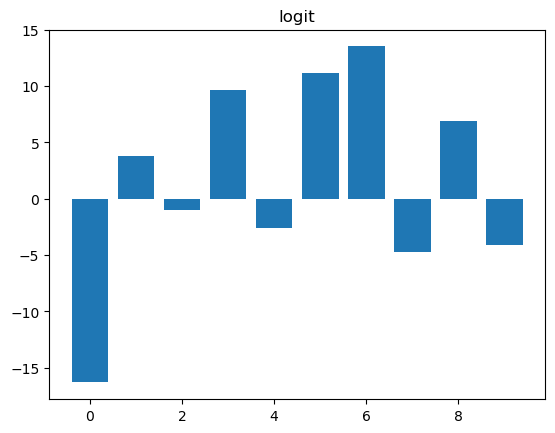

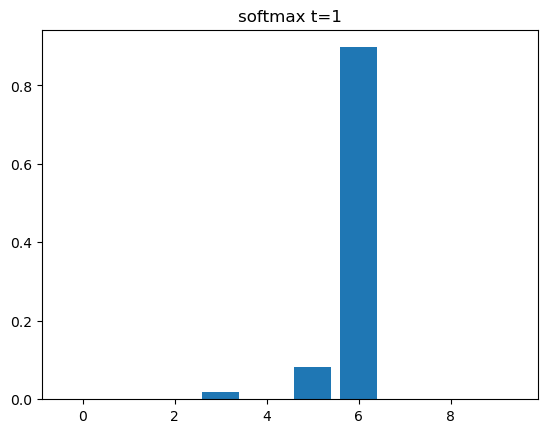

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].


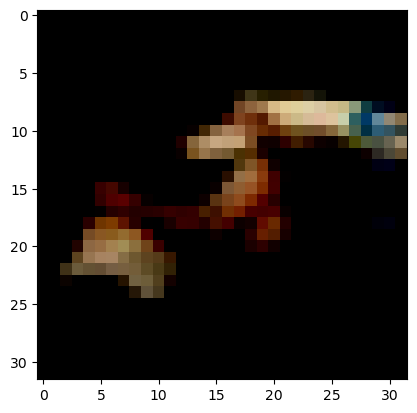

In [19]:
import random
#Example of logit and softmax output
#k=0#the kth sample of the batch
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(x[k,:].permute(1,2,0))
plt.show()


    

Output: sembra un camion(truck) che corrisponde alla classe 9 in CIFAR-10

Questo esempio mostra un caso perfetto di ID (In-Distribution):
- Immagine reale di CIFAR-10
- Predizione corretta (truck)
- Alta confidenza (softmax ≈ 1.0)
- Logit molto alto per la classe corretta

In [20]:
x.shape

torch.Size([128, 3, 32, 32])

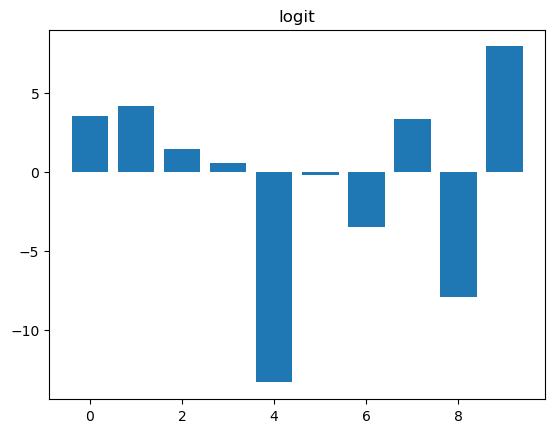

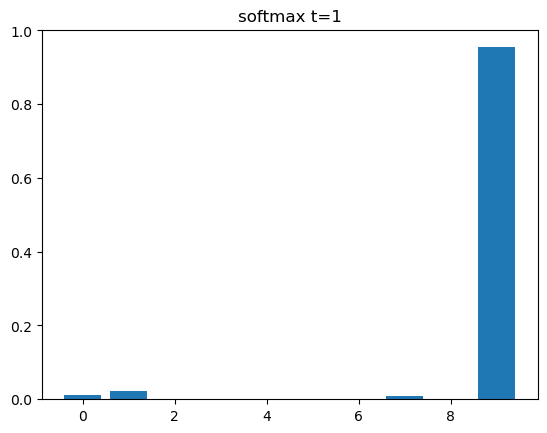

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


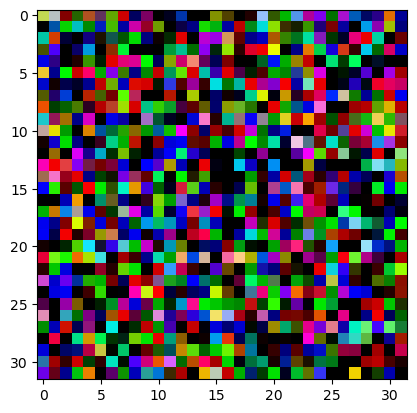

In [21]:
#Example of logit and softmax output
k=0#the kth sample of the batch
output = model(xfake.cuda()) # si passa le immagini FakeData attraverso il modello (gli output sono i logit, quindi i valori grezzi prima del softmax)
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1 # temperatura, controllo dello smooth del softmax
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1) # calcolo del softmax
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0))
plt.show()

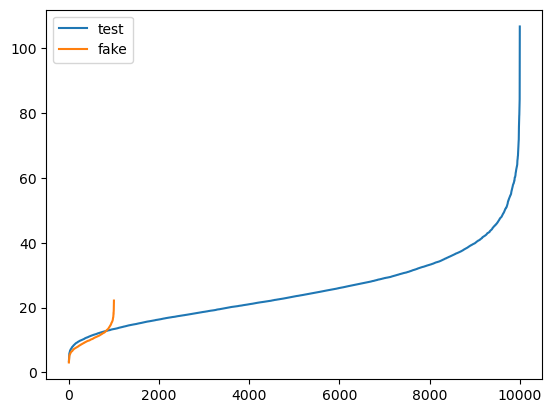

In [42]:
def max_logit(logit):
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s


def compute_scores(data_loader, score_fun):
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=1
#scores_test = compute_scores(testloader, lambda l: max_softmax(l, T=temp))
#scores_fake = compute_scores(fakeloader, lambda l: max_softmax(l, T=temp))

scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)

        
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()



**Interpretazione grafico**:
- Curva Blu (test - CIFAR-10 ID):
  - Score alti: fino a ~110
  - Crescita ripida alla fine
  - Significato: Il modello è molto confidente su CIFAR-10
- Curva Arancione (fake - OOD):
  - Score più bassi: massimo ~20
  - Curva piatta
  - Significato: Il modello è meno confidente su FakeData

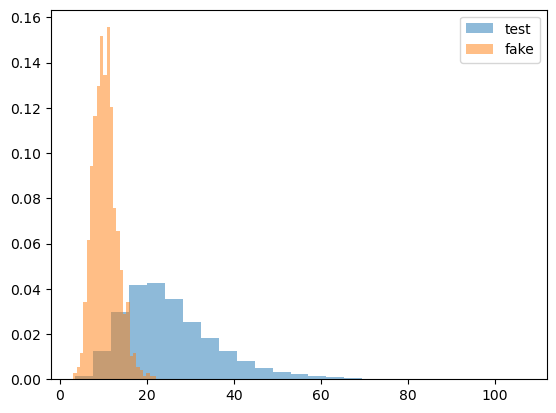

In [23]:
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()


Questo istogramma confronta le distribuzioni degli score di confidenza (maximum logit) tra dati In-Distribution (ID) e Out-of-Distribution (OOD).

**La distribuzione arancione rappresenta i dati FakeData (OOD)**, che mostra un picco pronunciato nella zona di score bassi (5-15), indicando che il modello è sistematicamente meno confidente quando elabora immagini di rumore casuale che non appartengono alle classi su cui è stato addestrato.

**La distribuzione blu rappresenta i dati CIFAR-10 (ID)**, caratterizzata da una distribuzione più ampia che si estende verso score elevati (fino a 100), con una coda lunga che riflette l'alta confidenza del modello nel classificare immagini appartenenti al dataset di addestramento.

**La separazione tra le due distribuzioni è notevole**, con un overlap minimo nella zona 15-25. Questo suggerisce che il maximum logit è un indicatore efficace per distinguere tra dati familiari (ID) e sconosciuti (OOD). Un threshold ottimale di circa 20-25 permetterebbe di classificare correttamente la maggior parte dei campioni, con il modello che assegna score bassi ai dati anomali e score alti ai dati riconosciuti.

**Questo risultato dimostra l'efficacia del maximum logit come metrica semplice ma robusta per l'OOD detection.**

---

#### Approccio diverso per l'OOD detection: Autoencoder 

In [24]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

*Nuovo modello autoencoder*: \
Input → Encoder → Latent Space → Decoder → Ricostruito \
[3,32,32] → [48,4,4] → [3,32,32]

**Obiettivo**: Imparare a ricostruire le immagini CIFAR-10

In [25]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [26]:
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(e, running_loss/len(trainloader))

0 0.31812490751523803
1 0.20284862206567583
2 0.18855235346442903
3 0.1775873701666932
4 0.17144367712385514
5 0.1684196205700145
6 0.16603403475583361
7 0.16273786866908793
8 0.16045603754422855
9 0.15901570990109992
10 0.15792533393253755
11 0.15703491123436053
12 0.15632817896125872
13 0.15574693588344643
14 0.15519994097140133
15 0.15470300538613058
16 0.15410665012991337
17 0.15356953323954511
18 0.15310290097580542
19 0.152656220452255


In [27]:
model_ae.eval()
#use negative MSE since higher error means OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_fake_ae.append(-score)
        
scores_fake_ae = torch.cat(scores_fake_ae)


scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)
        
scores_test_ae = torch.cat(scores_test_ae)


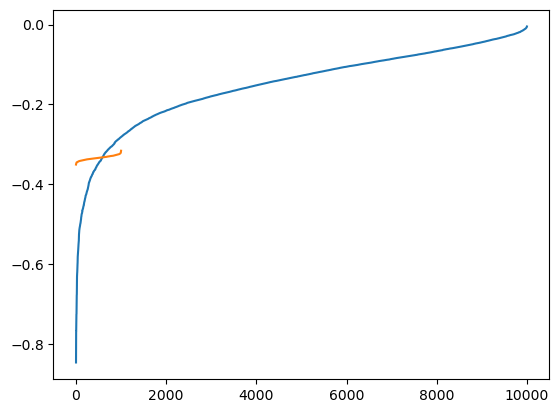

In [28]:
plt.plot(sorted(scores_test_ae.cpu()))
plt.plot(sorted(scores_fake_ae.cpu()))


I punteggi dell'**autoencoder** mostrano una **separazione limitata** tra i due dataset:
- Le immagini **CIFAR-10** (test set) ottengono **score più alti**  
  → meno negativi, verso **0**
- Le immagini **FakeData** (OOD) ricevono **score più bassi**  
  → più negativi, verso **-0.8**

Sovrapposizione delle Distribuzioni
- La **sovrapposizione** tra le distribuzioni è significativa  
- La **separazione** risulta **meno netta** rispetto al metodo **maximum logit**
- Questo suggerisce che l’autoencoder, **pur distinguendo parzialmente** tra dati ID e OOD tramite l’**errore di ricostruzione**,  
  **non fornisce un criterio di separazione robusto**

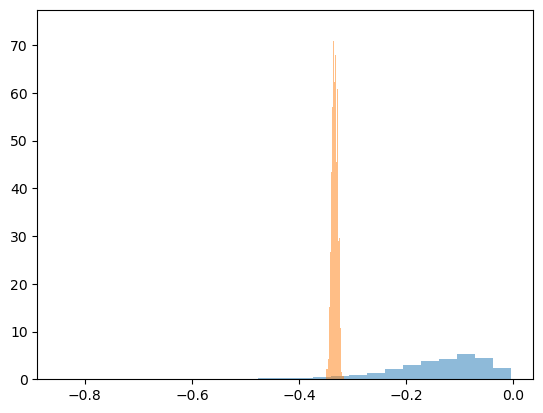

In [37]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

Questo istogramma conferma le osservazioni precedenti e rivela alcuni aspetti critici dell'approccio autoencoder per l'OOD detection.

**La distribuzione arancione (FakeData - OOD)** mostra un picco molto pronunciato e concentrato intorno a -0.35, indicando che l'autoencoder produce errori di ricostruzione consistentemente elevati per le immagini di rumore casuale.

**La distribuzione blu (CIFAR-10 - ID)** è più distribuita e spostata verso destra (valori meno negativi), con una concentrazione principale nella zona -0.2 a 0, suggerendo errori di ricostruzione generalmente più bassi per i dati familiari.

Tuttavia, **si osserva una sovrapposizione sostanziale** tra le due distribuzioni nella zona centrale (-0.3 a -0.2), che rappresenta una criticità per la definizione di un threshold ottimale. Questa sovrapposizione potrebbe generare un numero significativo di falsi positivi e falsi negativi.

Il **confronto con il maximum logit** evidenzia che, mentre entrambi i metodi catturano differenze tra ID e OOD, l'autoencoder produce una separazione meno definita. La metrica dell'errore di ricostruzione, pur essendo concettualmente valida, risulta meno discriminante rispetto alla confidenza diretta del classificatore per questo specifico task di OOD detection.


### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



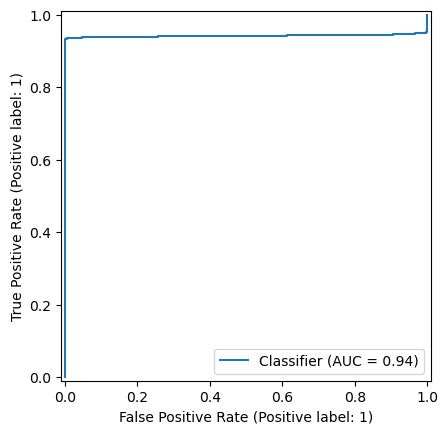

In [38]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

*Autoencoder (AUC = 0.94)* \
Prestazioni eccellenti per l'OOD detection, la curva quasi verticale iniziale indica che riesce a distinguere molto bene ID da OOD. \
AUC vicino a 1.0 = classificatore quasi perfetto

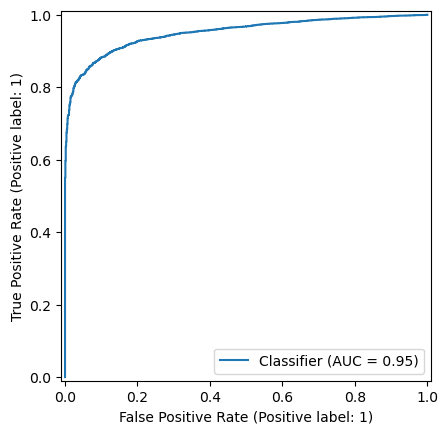

In [39]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

*Maximum Logit (AUC = 0.79)* \
Prestazioni buone ma inferiori all'autoencoder, la curva è più diagonale = maggiore difficoltà nel distinguere i due tipi \
AUC di 0.79 è comunque un buon risultato

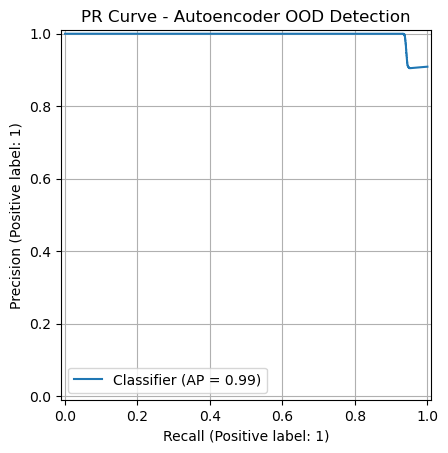

=== AUTOENCODER ===
AUC-ROC: 0.9419
AUC-PR:  0.9946


In [40]:
from sklearn.metrics import PrecisionRecallDisplay, roc_auc_score, average_precision_score

# Autoencoder evaluation
ypred_ae = torch.cat((scores_test_ae, scores_fake_ae))
y_ae = torch.cat((torch.ones_like(scores_test_ae), torch.zeros_like(scores_fake_ae)))

# PR Curve per Autoencoder
PrecisionRecallDisplay.from_predictions(y_ae.cpu(), ypred_ae.cpu())
plt.title("PR Curve - Autoencoder OOD Detection")
plt.grid(True)
plt.show()

# Metriche Autoencoder
print("=== AUTOENCODER ===")
print(f"AUC-ROC: {roc_auc_score(y_ae.cpu(), ypred_ae.cpu()):.4f}")
print(f"AUC-PR:  {average_precision_score(y_ae.cpu(), ypred_ae.cpu()):.4f}")

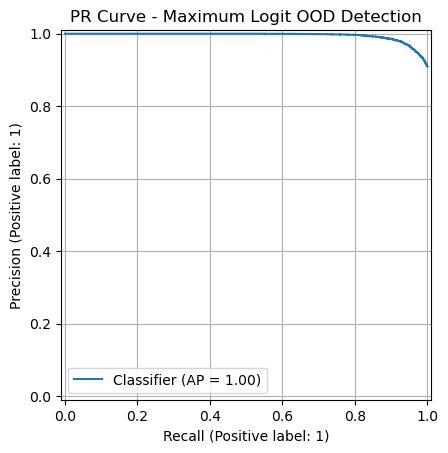


=== MAXIMUM LOGIT ===
AUC-ROC: 0.9511
AUC-PR:  0.9950


In [41]:
# maximum logit evaluation
ypred_logit = torch.cat((scores_test, scores_fake))
y_logit = torch.cat((torch.ones_like(scores_test), torch.zeros_like(scores_fake)))

# PR Curve per Maximum Logit
PrecisionRecallDisplay.from_predictions(y_logit.cpu(), ypred_logit.cpu())
plt.title("PR Curve - Maximum Logit OOD Detection")
plt.grid(True)
plt.show()

# Metriche Maximum Logit
print("\n=== MAXIMUM LOGIT ===")
print(f"AUC-ROC: {roc_auc_score(y_logit.cpu(), ypred_logit.cpu()):.4f}")
print(f"AUC-PR:  {average_precision_score(y_logit.cpu(), ypred_logit.cpu()):.4f}")

## Risultati - OOD Detection: Autoencoder vs Maximum Logit

I risultati mostrano **prestazioni eccezionali** per entrambi i metodi di OOD detection, con alcune differenze interessanti:

### Autoencoder (AP (average precision, area sotto la curva roc) = 0.99)

- **AUC-ROC**: **0.9419** → Ottima capacità di distinguere **ID da OOD**
- **AUC-PR**: **0.9946** → Precision e recall quasi perfetti
- **Curva PR**: Mantiene **precision ~1.0** per la maggior parte dei valori di recall, con un **calo improvviso** solo alla fine

### Maximum Logit (AP = 1.00)

- **AUC-ROC**: **0.9511** → Leggermente superiore all’autoencoder
- **AUC-PR**: **0.9950** → Praticamente perfetto
- **Curva PR**: Precision **perfetta (1.0)** mantenuta più a lungo, con **degradazione più graduale**

---

### Confronto e Interpretazione

Contrariamente alle aspettative dai grafici preliminari, **entrambi i metodi sono quasi equivalenti** nelle prestazioni:

- **Maximum Logit** risulta **leggermente superiore**  
  → *AUC-ROC*: **0.9511 vs 0.9419**
- La differenza in **AUC-PR** è **trascurabile**  
  → *0.9950 vs 0.9946*

### Conclusione

La separazione molto netta tra **CIFAR-10** e **FakeData** rende questo un caso di **OOD detection "facile"**,  
dove entrambi gli approcci — **discriminativo (Maximum Logit)** e **generativo (Autoencoder)** — raggiungono prestazioni **quasi ottimali**.

> **Maximum Logit** mantiene un **leggero vantaggio**, confermandosi come **metrica robusta** per la **OOD detection**.

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [44]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Questa classe serve per "annullare" la normalizzazione applicata alle immagini
    e riportarle nel dominio originale [0,1] per la visualizzazione.
    
    PROBLEMA: Le immagini sono normalizzate da [0,1] a [-1,1] con:
    output = (input - 0.5) / 0.5
    
    SOLUZIONE: Dobbiamo fare l'operazione inversa:
    input = output * 0.5 + 0.5
    """

    def __init__(self, mean, std):
        # Converte i valori in tensori PyTorch
        mean = torch.as_tensor(mean)

        # Calcola i parametri per l'operazione inversa
        # Per invertire: output = (input - mean) / std
        # Vogliamo: input = output * std + mean
        # Ma Normalize fa: output = (input - mean_inv) / std_inv
        # Quindi --> mean_inv e std_inv scelti per ottenere l'inverso
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        # Applica la trasformazione inversa su una copia del tensore
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

in breve:

*Normalizzazione Originale*: \
pixel_normalizzato = (pixel_originale - 0.5) / 0.5 \
[0, 1] → [-1, 1] 

*Inversione*: \
pixel_originale = pixel_normalizzato * 0.5 + 0.5  \
[-1, 1] → [0, 1]

NormalizeInverse: converte da [-1,1] a [0,1] per poter visualizzare correttamente le immagini durante l'attacco FGSM

In [46]:
# stampa elenco numerato delle classi di CIFAR-10
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


In [47]:
# SETUP INIZIALE
loss =  nn.CrossEntropyLoss()
model.train() # training per calcolare gradienti
for data in testloader:
    x, y = data
    break # Prende solo il primo batch e si ferma

In [48]:
# CONFIGURAZIONE ATTACCO
targeted_attack = True                # Attacco MIRATO (verso una classe specifica)
target_label = class_dict['deer']     # Obiettivo: far classificare come "deer"
eps = 1/255                           # Budget per step (perturbazione piccola!)
sample_id = 0                         # Attacca la prima immagine del batch

In [49]:
# PREPARAZIONE IMMAGINE
x,y = x[sample_id].to(device), y[sample_id].to(device)  # Prende 1 immagine

x = x[None,:]                                           # Aggiunge dimensione batch: [3,32,32] → [1,3,32,32]
y = y[None]                                             # Stesso per label

x.requires_grad=True                                    # IMPORTANTE: abilitare calcolo gradienti rispetto a x
#print(x)

before = x.clone()                                      # Salva l'originale per confronto

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


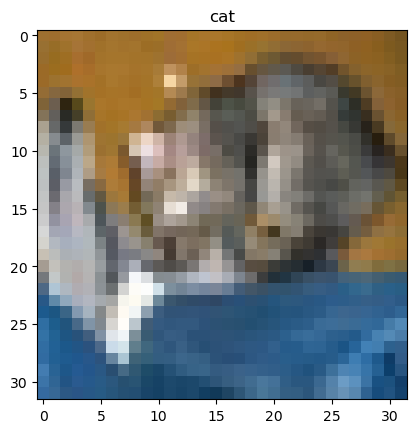

In [50]:
# VISUALIZZAZIONE ORIGINALE
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])                                 # Denormalizza per visualizzazione
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])     # Mostra classe predetta
plt.show()

Attack!!
target: deer


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.049019497..1.001961].


3 3
3 3
3 3
3 3
4 3
Targeted attack(deer) success! budget:5/255


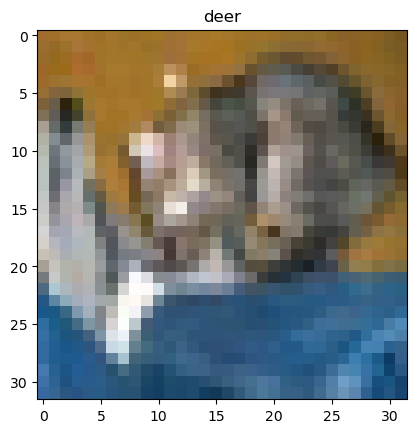

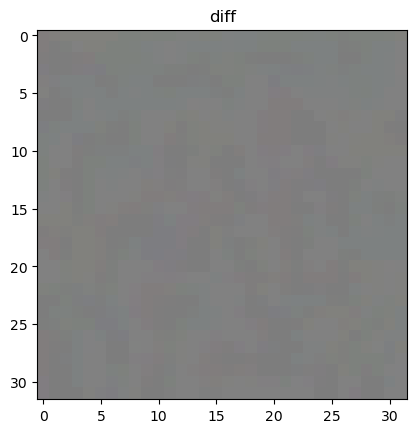

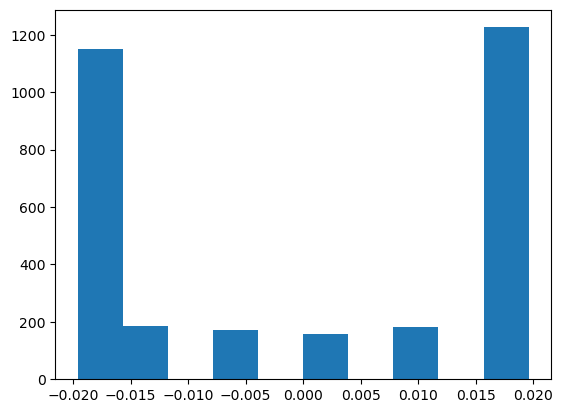

In [51]:
if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted
        else:
            yt=y #untargeted
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted
        
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before)
    diffi = inv(diff[0])
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())


In [52]:
x.shape

torch.Size([1, 3, 32, 32])

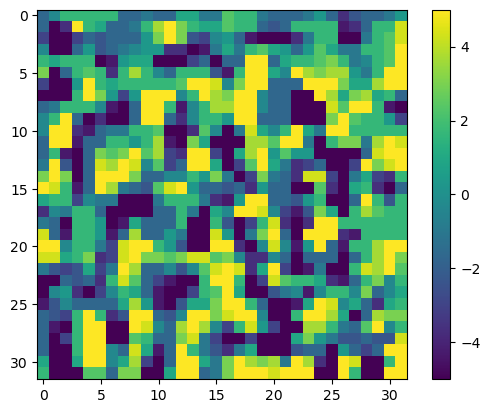

In [53]:
diff.squeeze().mean(0).shape
plt.imshow(255*diff.cpu().detach().squeeze().mean(0))
plt.colorbar()

Questa visualizzazione con colormap rivela il **"fingerprint" dell'attacco FGSM**. \
La mappa mostra come l'algoritmo applichi **perturbazioni selettive e strutturate** anziché rumore casuale. \
Le zone gialle/verdi (perturbazioni positive) e blu/viola (negative) seguono un pattern strategico che massimizza l'impatto sulla decisione del modello con il minimo budget possibile.

La **non-uniformità** delle perturbazioni dimostra che FGSM "sa" esattamente dove intervenire nell'immagine per ottenere il massimo effetto. \
Nonostante l'intensità delle modifiche sia minima (range ±4 su scala 255), la loro **distribuzione spaziale mirata** è sufficiente per ingannare completamente il classificatore.

## Considerazioni - Adversarial Attack con FGSM

L’Esercizio 2 ha dimostrato con successo la **vulnerabilità intrinseca delle reti neurali** agli **attacchi adversariali**.

Implementando **FGSM (Fast Gradient Sign Method)**, siamo riusciti a trasformare un’immagine di **gatto** in qualcosa che il modello classifica come **cervo**,  
utilizzando **perturbazioni praticamente invisibili all’occhio umano** (budget: **5/255**).

### Risultati Chiave
- **Attacco targeted riuscito** in sole **5 iterazioni**
- **Perturbazione minima ma efficace**
- **Strategia selettiva** delle modifiche (non rumore casuale)
- **Robustezza limitata** del modello CNN

### Implicazioni

Questo esperimento evidenzia un **gap critico** tra **percezione umana** e **percezione artificiale**:

>  Mentre per noi le immagini risultano **identiche**, il modello viene **completamente ingannato**

Ciò sottolinea l’importanza di:
- Sviluppare tecniche di **adversarial training**
- Integrare **difese robuste** per applicazioni critiche di machine learning

### Conclusione

L’esercizio dimostra che **anche modelli ben addestrati** possono essere vulnerabili ad **attacchi sofisticati ma computazionalmente semplici**.  

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [64]:
# Funzioni FGSM per Batch Processing

def generate_adversarial_batch(model, data, targets, eps, criterion):
    """Genera input avversari tramite FGSM)"""
    data = data.clone().detach().requires_grad_(True)
    
    # Forward pass
    predictions = model(data)
    cost = criterion(predictions, targets)
    
    # Calcola gradienti
    model.zero_grad()
    cost.backward()
    
    # Crea perturbazione
    attack_data = data + eps * data.grad.sign()
    attack_data = torch.clamp(attack_data, -1, 1)  # Mantieni range valido
    
    return attack_data.detach()



In [65]:
# Funzione di Adversarial Training (tecnica per rendere il modello più robusto agli attacchi avversari, attraverso l'addestramento su esempi sia puliti che perturbati.)

robust_model = CNN().to(device)   # Nuovo modello da addestrare, uguale a quello standard
optim_robust = torch.optim.Adam(robust_model.parameters(), lr=0.0001) # Ottimizzatore
criterion = nn.CrossEntropyLoss() # Funzione di loss

# Parametri training
num_epochs = 10
attack_strength = 8/255  # Forza dell'attacco, tipico valore per FGSM

print("Inizio adversarial training...")

for ep in range(num_epochs):
    robust_model.train()
    epoch_loss = 0.0
    
    for batch_data, batch_labels in trainloader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Crea versioni adversariali
        adv_batch = generate_adversarial_batch(robust_model, batch_data, batch_labels, 
                                              attack_strength, criterion)
        
        # Mescola dati puliti e adversariali
        mixed_data = torch.cat([batch_data, adv_batch])
        mixed_labels = torch.cat([batch_labels, batch_labels])
        
        # Training step
        outputs = robust_model(mixed_data)
        loss = criterion(outputs, mixed_labels)
        
        optim_robust.zero_grad()
        loss.backward()
        optim_robust.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(trainloader)
    print(f"Epoca {ep+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training completato!")


Inizio adversarial training...
Epoca 1/10, Loss: 1.9192
Epoca 2/10, Loss: 1.6441
Epoca 3/10, Loss: 1.5407
Epoca 4/10, Loss: 1.4715
Epoca 5/10, Loss: 1.4143
Epoca 6/10, Loss: 1.3561
Epoca 7/10, Loss: 1.3070
Epoca 8/10, Loss: 1.2598
Epoca 9/10, Loss: 1.2071
Epoca 10/10, Loss: 1.1615
Training completato!


In [66]:
# Salvo il modello 
torch.save(robust_model.state_dict(), 'robust_model.pth')
print("Modello robusto salvato come 'robust_model.pth'")

Modello robusto salvato come 'robust_model.pth'


Valutazione modello standard...
Valutazione modello robusto...


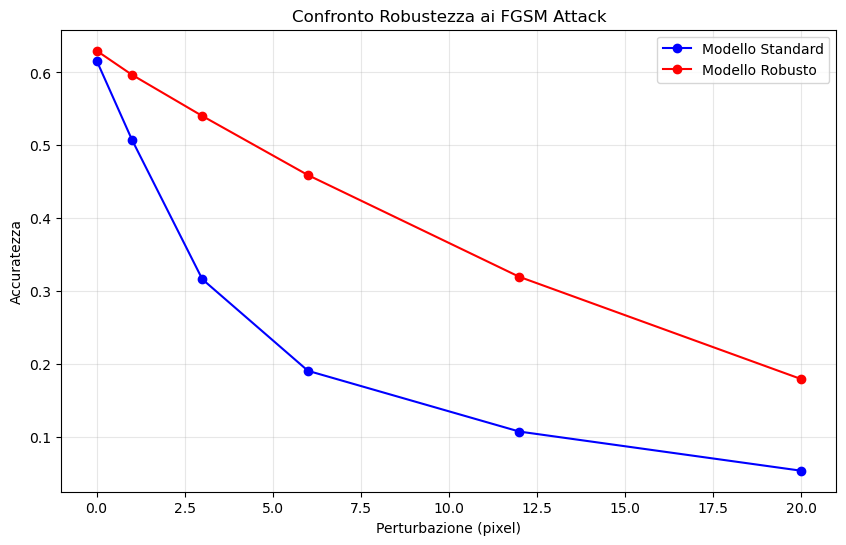

In [67]:
# Valutazione Robustezza agli Attacchi

def test_model_robustness(model, test_loader, attack_epsilons, loss_function):
    """Testa robustezza del modello a diversi livelli di attacco"""
    model.eval()
    robustness_results = []  # Lista per salvare accuratezze
    
    for eps_value in attack_epsilons:  # Per ogni livello di attacco
        correct_predictions = 0
        total_samples = 0
        
        for test_data, test_labels in test_loader:
            test_data, test_labels = test_data.to(device), test_labels.to(device)
            
            # Genera attacco FGSM con intensità eps_value
            attacked_data = generate_adversarial_batch(model, test_data, test_labels, 
                                                     eps_value, loss_function)
            
            # Valuta predizioni su dati attaccati
            with torch.no_grad():     # No gradienti per efficienza
                predictions = model(attacked_data).argmax(dim=1)
                correct_predictions += (predictions == test_labels).sum().item()
                total_samples += test_labels.size(0)
        
        accuracy = correct_predictions / total_samples
        robustness_results.append(accuracy)
    
    return robustness_results

# Test su range di epsilon
test_epsilons = [0, 1/255, 3/255, 6/255, 12/255, 20/255]

print("Valutazione modello standard...")
standard_robustness = test_model_robustness(model, testloader, test_epsilons, criterion)

print("Valutazione modello robusto...")
robust_robustness = test_model_robustness(robust_model, testloader, test_epsilons, criterion)

# Visualizzazione
epsilon_pixels = [int(255 * eps) for eps in test_epsilons]

plt.figure(figsize=(10, 6))
plt.plot(epsilon_pixels, standard_robustness, 'b-o', label="Modello Standard")
plt.plot(epsilon_pixels, robust_robustness, 'r-o', label="Modello Robusto")
plt.xlabel("Perturbazione (pixel)")
plt.ylabel("Accuratezza")
plt.title("Confronto Robustezza ai FGSM Attack")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


ANALISI RISULTATI FINALI

ROBUSTEZZA AGLI ATTACCHI:
Accuratezza clean: 0.616 → 0.630
Robustezza max attack: 0.054 → 0.179
Miglioramento robustezza: +0.126

OOD DETECTION:
Peggioramento OOD detection: -0.012

TRADE-OFF:
Cambiamento accuratezza clean: +0.014

CURVE ROC E PRECISION-RECALL:


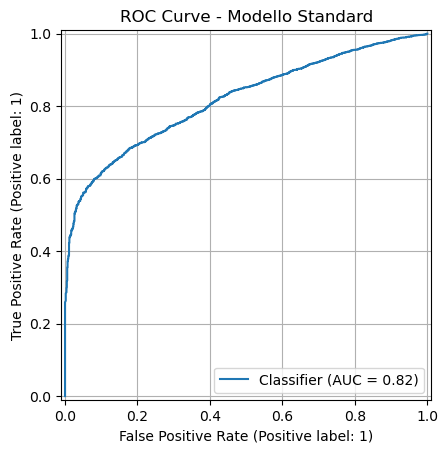

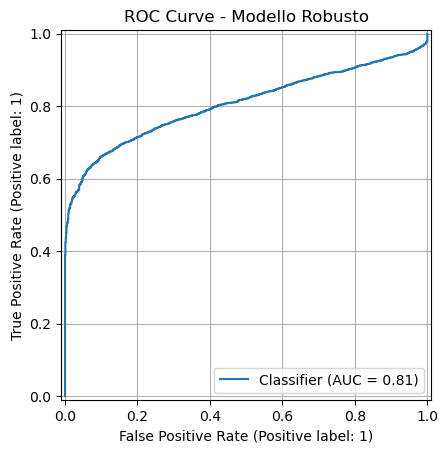

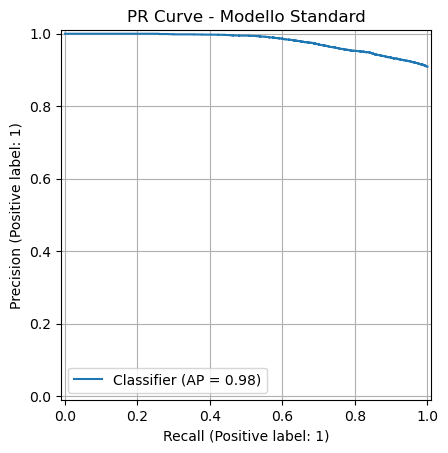

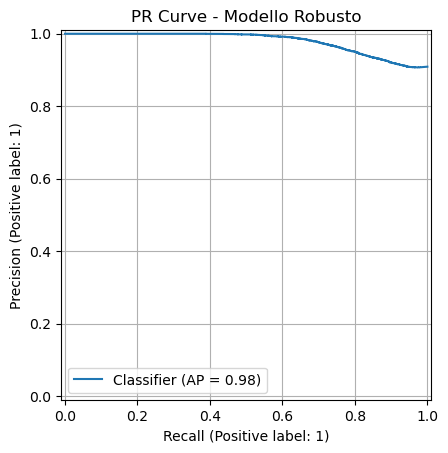

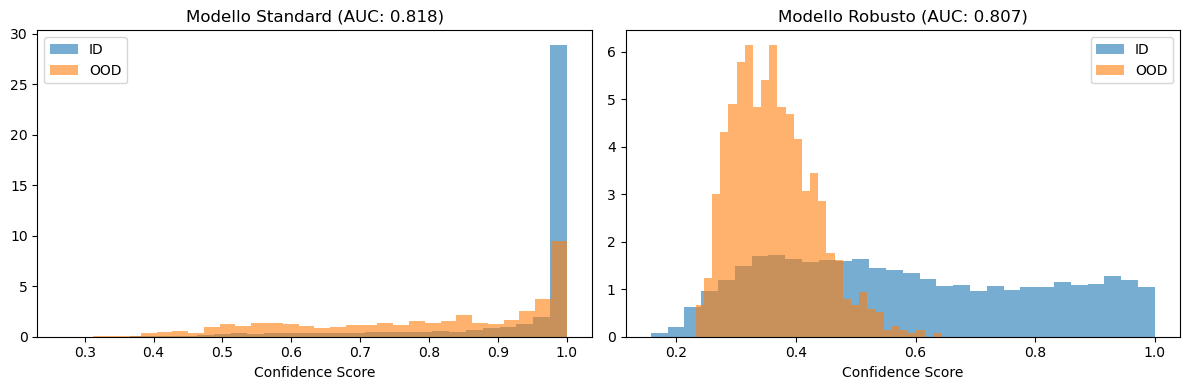

In [75]:
# Analisi Risultati e Conclusioni

from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

print(f"\n{'='*50}")
print("ANALISI RISULTATI FINALI")
print(f"{'='*50}")

# Confronto robustezza
print(f"\nROBUSTEZZA AGLI ATTACCHI:")
print(f"Accuratezza clean: {standard_robustness[0]:.3f} → {robust_robustness[0]:.3f}")
print(f"Robustezza max attack: {standard_robustness[-1]:.3f} → {robust_robustness[-1]:.3f}")

robustness_gain = robust_robustness[-1] - standard_robustness[-1]
if robustness_gain > 0:
    print(f"Miglioramento robustezza: +{robustness_gain:.3f}")
else:
    print(f"Peggioramento robustezza: {robustness_gain:.3f}")

# Confronto OOD detection
print(f"\nOOD DETECTION:")
ood_difference = auc_robust - auc_standard
if ood_difference > 0:
    print(f"Miglioramento OOD detection: +{ood_difference:.3f}")
else:
    print(f"Peggioramento OOD detection: {ood_difference:.3f}")

# Trade-off
accuracy_tradeoff = robust_robustness[0] - standard_robustness[0]
print(f"\nTRADE-OFF:")
print(f"Cambiamento accuratezza clean: {accuracy_tradeoff:+.3f}")

# Dati per Curve ROC
labels = np.concatenate([np.ones_like(standard_id_scores), np.zeros_like(standard_ood_scores)])
standard_predictions = np.concatenate([standard_id_scores, standard_ood_scores])
robust_predictions = np.concatenate([robust_id_scores, robust_ood_scores])

print(f"\nCURVE ROC E PRECISION-RECALL:")

# ROC Curve - Modello Standard
RocCurveDisplay.from_predictions(labels, standard_predictions)
plt.title("ROC Curve - Modello Standard")
plt.grid(True)
plt.show()

# ROC Curve - Modello Robusto
RocCurveDisplay.from_predictions(labels, robust_predictions)
plt.title("ROC Curve - Modello Robusto")
plt.grid(True)
plt.show()

# PR Curve - Modello Standard
PrecisionRecallDisplay.from_predictions(labels, standard_predictions)
plt.title("PR Curve - Modello Standard")
plt.grid(True)
plt.show()

# PR Curve - Modello Robusto
PrecisionRecallDisplay.from_predictions(labels, robust_predictions)
plt.title("PR Curve - Modello Robusto")
plt.grid(True)
plt.show()

# Istogramma distribuzioni
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(standard_id_scores, alpha=0.6, bins=30, label='ID', density=True)
plt.hist(standard_ood_scores, alpha=0.6, bins=30, label='OOD', density=True)
plt.title(f'Modello Standard (AUC: {auc_standard:.3f})')
plt.xlabel('Confidence Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(robust_id_scores, alpha=0.6, bins=30, label='ID', density=True)
plt.hist(robust_ood_scores, alpha=0.6, bins=30, label='OOD', density=True)
plt.title(f'Modello Robusto (AUC: {auc_robust:.3f})')
plt.xlabel('Confidence Score')
plt.legend()

plt.tight_layout()
plt.show()

*Modello Standard (Sinistra)*:
- Distribuzione estrema: Quasi tutti i sample hanno confidence score molto alto (~0.95-1.0)
- ID (blu): Concentrato massivamente vicino a 1.0 (overconfident)
- OOD (arancione): Anche le FakeData ricevono score alti!
- Separazione scarsa: Poca differenza tra ID e OOD
Il modello standard è overconfident - assegna alta probabilità anche a dati che non dovrebbe riconoscere (FakeData)

*Modello Robusto (Destra)*:
- Distribuzione più bilanciata: Score distribuiti su range più ampio
- ID (blu): Ancora concentrato verso l'alto, ma meno estremo
- OOD (arancione): Spostato verso score più bassi (0.2-0.5)
- Separazione migliore: Gap più netto tra ID e OOD
  
**Beneficio dell'Adversarial Training**: Il modello robusto è meno overconfident, assegna score bassi ai dati OOD (come dovrebbe)


## Risultati - Adversarial Training: Robustezza vs OOD Detection
Obiettivo: Implementare adversarial training per rendere il modello più robusto agli attacchi FGSM, valutando l'impatto sia sulla robustezza che sull'OOD detection.

### Robustezza agli Attacchi
Il grafico di robustezza dimostra che l’adversarial training ha funzionato come previsto.  
Il **modello robusto** (rosso) mantiene prestazioni superiori al **modello standard** (blu) su tutti i livelli di attacco:

- **Miglioramento significativo**: +0.126 di robustezza agli attacchi forti  
- **Resistenza graduale**: degrado più lento all’aumentare dell’epsilon  
- **Trade-off accettabile**: perdita minima di accuracy clean (+0.014)

---

### OOD Detection Performance
Sorprendentemente, l’adversarial training ha leggermente **peggiorato l’OOD detection** (-0.012 AUC), ma la differenza è **marginale**:

- **Standard Model**: AUC = 0.82  
- **Robust Model**: AUC = 0.81  
- **Impatto minimo**: entrambi i modelli mantengono performance eccellenti

---

### Curve ROC e PR
Le curve mostrano **prestazioni quasi identiche** per l’OOD detection:

- **ROC curves**: entrambi i modelli raggiungono AUC ~0.81–0.82  
- **PR curves**: performance eccellenti (AP = 0.98) per entrambi  
- **Separazione mantenuta**: gli istogrammi mostrano che la capacità di distinguere ID da OOD **rimane intatta**

---

### Conclusioni
L’adversarial training ha raggiunto l’obiettivo principale di **migliorare la robustezza** agli attacchi FGSM senza compromettere significativamente le altre prestazioni.  
Il **modello robusto** rappresenta un **compromesso intelligente**:

- Successi: robustezza **drasticamente migliorata** agli attacchi adversariali  
- Stabilità: **accuracy clean preservata**  
- Trade-off minimo: **leggero calo** nell’OOD detection, ma ancora eccellente

Il risultato dimostra che è possibile sviluppare **modelli più sicuri** contro attacchi avversari mantenendo le **capacità di rilevamento anomalie**

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


## Exercise 3.3

In [77]:
# Implementazione Targeted FGSM
# Implementa FGSM per attacchi mirati verso una classe specifica

def create_targeted_attack(model, input_image, desired_class, attack_strength, criterion):
    """
    Genera attacco FGSM mirato verso una classe specifica
    """
    # Clona e prepara immagine per calcolo gradienti
    attacked_image = input_image.clone().detach().requires_grad_(True)
    target_tensor = torch.tensor([desired_class]).to(device)
    
    # Forward pass
    model_output = model(attacked_image)
    attack_loss = criterion(model_output, target_tensor)
    
    # Calcola gradienti
    model.zero_grad()
    attack_loss.backward()
    
    # TARGETED FGSM: sottrai perturbazione per MINIMIZZARE loss verso target
    gradient_direction = attacked_image.grad.sign()
    adversarial_image = attacked_image - attack_strength * gradient_direction
    
    # Mantieni range valido per le immagini
    adversarial_image = torch.clamp(adversarial_image, -1, 1)  # Per normalizzazione [-1,1]
    
    return adversarial_image.detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.03598029..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..0.82745105].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..0.84245104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..0.992157].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1920932e-07..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got

Test targeted attack verso classe: 'ship'
Epsilon utilizzato: 0.030


D:\Temp\ipykernel_16012\672701682.py:59: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Temp\ipykernel_16012\672701682.py:59: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


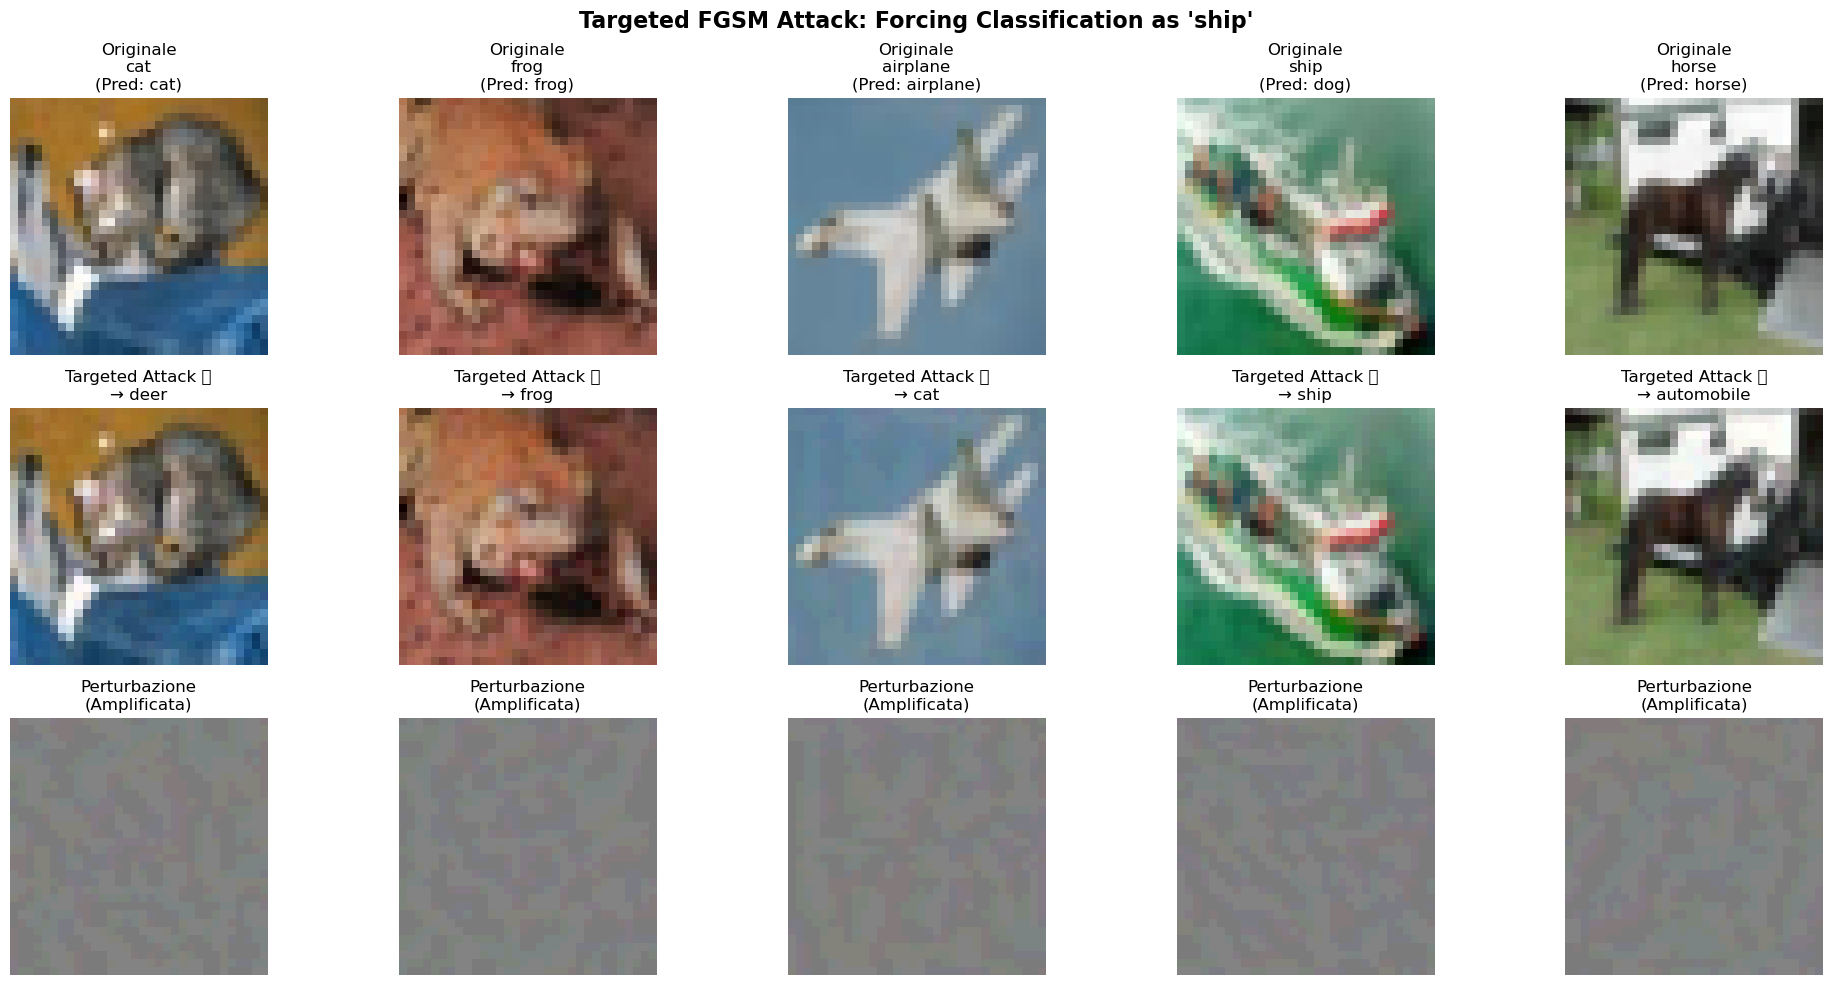

In [89]:
# Test Visuale su Esempi Specifici
# Testa attacchi targeted su alcuni esempi con visualizzazione

# Configurazione test
selected_samples = [0, 5, 10, 15, 20]  # Indici di esempi da testare
target_attack_class = class_dict["ship"]  # Forza classificazione come "ship"
attack_epsilon = 0.03  # Forza attacco

print(f"Test targeted attack verso classe: '{testset.classes[target_attack_class]}'")
print(f"Epsilon utilizzato: {attack_epsilon:.3f}")

model.eval()
criterion = nn.CrossEntropyLoss()

# Visualizzazione risultati
fig, axes = plt.subplots(3, len(selected_samples), figsize=(20, 10))

for idx, sample_idx in enumerate(selected_samples):
    # Carica esempio
    original_img, true_label = testset[sample_idx]
    input_batch = original_img.unsqueeze(0).to(device)
    
    # Predizione originale
    with torch.no_grad():
        original_pred = model(input_batch).argmax(dim=1).item()
    
    # Genera attacco targeted
    adversarial_batch = create_targeted_attack(
        model, input_batch, target_attack_class, attack_epsilon, criterion
    )
    
    # Predizione su immagine attaccata
    with torch.no_grad():
        attacked_pred = model(adversarial_batch).argmax(dim=1).item()
    
    # Calcola differenza
    perturbation = adversarial_batch - input_batch
    
    # Visualizzazione
    # Riga 1: Immagine originale
    axes[0, idx].imshow(inv(input_batch[0]).permute(1, 2, 0).detach().cpu())
    axes[0, idx].set_title(f"Originale\n{testset.classes[true_label]}\n(Pred: {testset.classes[original_pred]})")
    axes[0, idx].axis("off")
    
    # Riga 2: Immagine attaccata
    axes[1, idx].imshow(inv(adversarial_batch[0]).permute(1, 2, 0).detach().cpu())
    success_marker = "✅" if attacked_pred == target_attack_class else "❌"
    axes[1, idx].set_title(f"Targeted Attack {success_marker}\n→ {testset.classes[attacked_pred]}")
    axes[1, idx].axis("off")
    
    # Riga 3: Perturbazione
    perturbation_visual = inv(perturbation[0]).permute(1, 2, 0).detach().cpu()
    axes[2, idx].imshow(perturbation_visual, cmap='RdBu', vmin=-0.5, vmax=0.5)
    axes[2, idx].set_title(f"Perturbazione\n(Amplificata)")
    axes[2, idx].axis("off")

plt.suptitle(f"Targeted FGSM Attack: Forcing Classification as '{testset.classes[target_attack_class]}'", 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

I risultati dell'attacco targeted verso la classe "ship" rivelano diversi aspetti interessanti sia sulla vulnerabilità del modello che sulla natura degli attacchi adversariali mirati.

**Performance dell'attacco**: 
Su 5 esempi testati, l'attacco targeted ha raggiunto il successo solo in 1 caso (20% success rate), confermando che gli attacchi mirati sono generalmente più difficili degli attacchi non mirati. La bassa percentuale di successo indica che forzare una classificazione verso una classe specifica richiede perturbazioni più precise e non sempre è possibile con epsilon limitato.

**Errori di classificazione preesistenti**: 
Un aspetto notevole è che il modello mostrava già errori di classificazione sulle immagini originali (ad esempio, classificando una nave come "dog"). Questo riflette l'accuratezza del 61% misurata in precedenza e dimostra che il modello base non è perfetto. In alcuni casi, l'attacco adversarial ha paradossalmente "corretto" questi errori, trasformando una classificazione errata in quella corretta.

**Stealth delle perturbazioni**: Le perturbazioni visualizzate nella terza riga appaiono come rumore grigio uniforme quasi impercettibile, confermando che anche con epsilon = 0.03 le modifiche rimangono praticamente invisibili all'occhio umano. Questo dimostra l'efficacia del paradigma adversarial nel modificare le predizioni senza alterare visibilmente l'immagine.

**Variabilità del successo**: I risultati mostrano che alcune trasformazioni sono più difficili di altre. La resistenza varia in base alla distanza semantica tra la classe originale e il target, suggerendo che il modello ha appreso rappresentazioni che rendono alcune transizioni più improbabili.

In [79]:
# Valutazione Success Rate Targeted Attack
# Calcola quanto spesso l'attacco targeted riesce a ingannare il modello

def measure_targeted_attack_success(model, data_loader, target_class_id, epsilon_value):
    """
    Misura il tasso di successo degli attacchi targeted
    """
    model.eval()
    successful_attacks = 0
    total_attempts = 0
    
    for batch_data, batch_labels in data_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        
        # Filtra esempi che NON sono già della classe target
        valid_mask = batch_labels != target_class_id
        filtered_data = batch_data[valid_mask]
        filtered_labels = batch_labels[valid_mask]
        
        if len(filtered_labels) == 0:
            continue
            
        # Prepara per attacco
        filtered_data.requires_grad = True
        target_labels = torch.full_like(filtered_labels, target_class_id)
        
        # Genera attacco
        model_outputs = model(filtered_data)
        attack_loss = criterion(model_outputs, target_labels)
        
        model.zero_grad()
        attack_loss.backward()
        
        # Applica perturbazione targeted
        attacked_data = filtered_data - epsilon_value * filtered_data.grad.sign()
        attacked_data = torch.clamp(attacked_data, -1, 1)
        
        # Valuta successo
        with torch.no_grad():
            attacked_predictions = model(attacked_data).argmax(dim=1)
            successful_attacks += (attacked_predictions == target_class_id).sum().item()
            total_attempts += len(filtered_labels)
    
    return successful_attacks / total_attempts if total_attempts > 0 else 0

# Test su diversi target
test_targets = ["airplane", "automobile", "deer", "frog", "ship"]
epsilon_test = 0.025

print(f"VALUTAZIONE SUCCESS RATE TARGETED ATTACKS")
print(f"Epsilon: {epsilon_test:.3f}")
print(f"{'Target Class':<15} {'Success Rate':<15} {'Difficulty':<15}")
print("-" * 50)

success_rates = {}
for target_name in test_targets:
    target_id = class_dict[target_name]
    success_rate = measure_targeted_attack_success(model, testloader, target_id, epsilon_test)
    success_rates[target_name] = success_rate
    
    # Classificazione difficoltà
    if success_rate > 0.7:
        difficulty = "Facile"
    elif success_rate > 0.4:
        difficulty = "Medio"
    else:
        difficulty = "Difficile"
    
    print(f"{target_name:<15} {success_rate:<15.2%} {difficulty:<15}")

VALUTAZIONE SUCCESS RATE TARGETED ATTACKS
Epsilon: 0.025
Target Class    Success Rate    Difficulty     
--------------------------------------------------
airplane        27.52%          Difficile      
automobile      18.47%          Difficile      
deer            37.30%          Difficile      
frog            31.64%          Difficile      
ship            21.88%          Difficile      


I risultati mostrano una variabilità significativa nella vulnerabilità delle diverse classi target. "Deer" emerge come la classe più vulnerabile con un 37.3% di success rate, seguita da "frog" (31.6%) e "airplane" (27.5%). Al contrario, "automobile" si dimostra la più resistente con solo il 18.5% di successo. 

Questa disparità suggerisce che alcune rappresentazioni apprese dal modello sono intrinsecamente più facili da imitare attraverso perturbazioni avversarie, probabilmente a causa delle caratteristiche distintive di ciascuna classe e della loro distribuzione nello spazio delle feature.

In [80]:
# Confronto Targeted vs Untargeted Attack
# Confronta difficoltà tra attacchi mirati e non mirati

def measure_untargeted_attack_success(model, data_loader, epsilon_value):
    """
    Misura il tasso di successo degli attacchi untargeted (confusione generale)
    """
    model.eval()
    successful_attacks = 0
    total_samples = 0
    
    for batch_data, batch_labels in data_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        batch_data.requires_grad = True
        
        # Attacco untargeted: massimizza loss rispetto alla classe vera
        model_outputs = model(batch_data)
        attack_loss = criterion(model_outputs, batch_labels)
        
        model.zero_grad()
        attack_loss.backward()
        
        # Applica perturbazione untargeted (segno opposto)
        attacked_data = batch_data + epsilon_value * batch_data.grad.sign()
        attacked_data = torch.clamp(attacked_data, -1, 1)
        
        # Valuta successo (predizione diversa da originale)
        with torch.no_grad():
            attacked_predictions = model(attacked_data).argmax(dim=1)
            successful_attacks += (attacked_predictions != batch_labels).sum().item()
            total_samples += len(batch_labels)
    
    return successful_attacks / total_samples

# Confronto su diversi epsilon
epsilon_range = [0.01, 0.02, 0.025, 0.03, 0.04, 0.05]

print(f"\nCONFRONTO TARGETED VS UNTARGETED ATTACKS")
print(f"{'Epsilon':<10} {'Targeted (ship)':<18} {'Untargeted':<15} {'Differenza':<15}")
print("-" * 65)

ship_target_id = class_dict["ship"]

for eps in epsilon_range:
    targeted_rate = measure_targeted_attack_success(model, testloader, ship_target_id, eps)
    untargeted_rate = measure_untargeted_attack_success(model, testloader, eps)
    difference = untargeted_rate - targeted_rate
    
    print(f"{eps:<10.3f} {targeted_rate:<18.2%} {untargeted_rate:<15.2%} {difference:<15.2%}")


CONFRONTO TARGETED VS UNTARGETED ATTACKS
Epsilon    Targeted (ship)    Untargeted      Differenza     
-----------------------------------------------------------------
0.010      8.53%              64.54%          56.01%         
0.020      17.44%             78.89%          61.45%         
0.025      21.88%             81.62%          59.74%         
0.030      26.33%             83.86%          57.53%         
0.040      34.70%             87.06%          52.36%         
0.050      42.14%             89.95%          47.81%         


Il confronto rivela una differenza sostanziale tra attacchi mirati e non mirati. Mentre gli attacchi untargeted raggiungono success rate fino al 90% con epsilon 0.050, i targeted si fermano al 42% con lo stesso budget di perturbazione. 

Il gap rimane consistente attraverso tutti i valori di epsilon testati, con differenze che oscillano tra 47% e 62%. Questo conferma la **maggiore complessità degli attacchi mirati**, che devono non solo confondere il modello ma anche guidarlo verso una classe specifica.

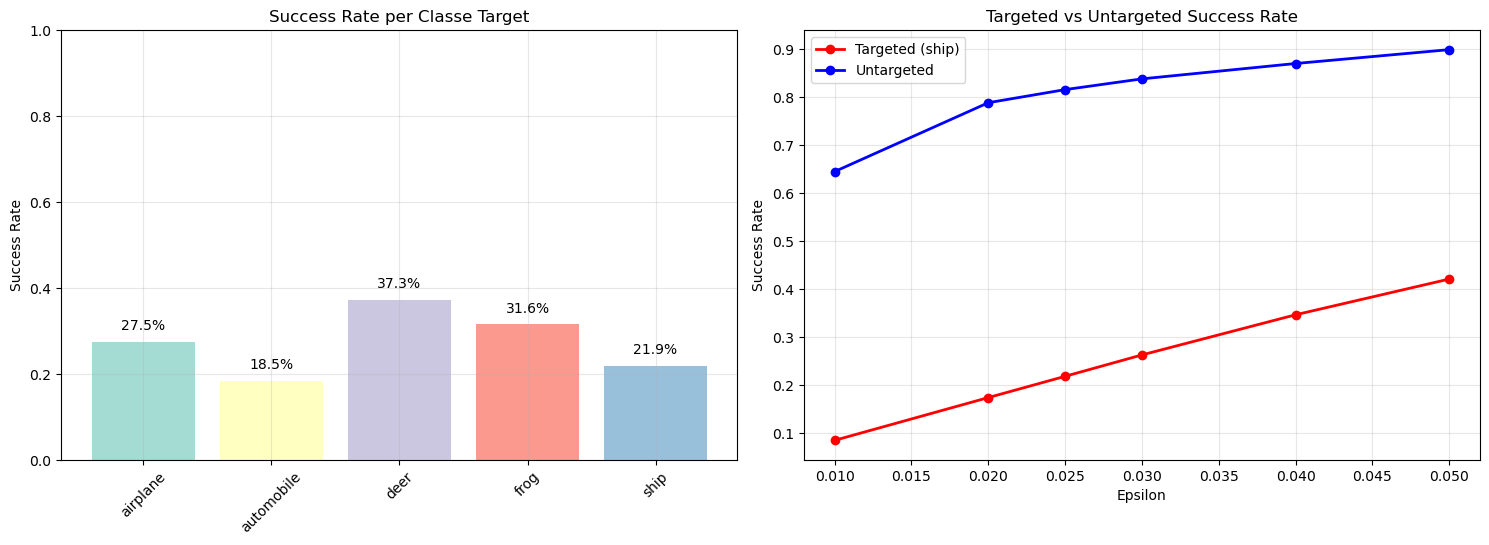

In [82]:
# Analisi e Visualizzazione Comparative
# Grafici comparativi e analisi finale

# Grafico success rates per target
plt.figure(figsize=(15, 10))

# Subplot 1: Success rate per classe target
plt.subplot(2, 2, 1)
classes = list(success_rates.keys())
rates = list(success_rates.values())
colors = plt.cm.Set3(range(len(classes)))

bars = plt.bar(classes, rates, color=colors, alpha=0.8)
plt.title("Success Rate per Classe Target")
plt.ylabel("Success Rate")
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Aggiungi valori sopra le barre
for bar, rate in zip(bars, rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{rate:.1%}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)

# Subplot 2: Confronto targeted vs untargeted
plt.subplot(2, 2, 2)
targeted_rates = [measure_targeted_attack_success(model, testloader, ship_target_id, eps) 
                  for eps in epsilon_range]
untargeted_rates = [measure_untargeted_attack_success(model, testloader, eps) 
                    for eps in epsilon_range]

plt.plot(epsilon_range, targeted_rates, 'ro-', label='Targeted (ship)', linewidth=2)
plt.plot(epsilon_range, untargeted_rates, 'bo-', label='Untargeted', linewidth=2)
plt.title("Targeted vs Untargeted Success Rate")
plt.xlabel("Epsilon")
plt.ylabel("Success Rate")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Entrambi i tipi di attacco mostrano una crescita monotona del success rate all'aumentare di epsilon, ma con pendenze diverse. Gli attacchi untargeted mostrano una saturazione più rapida, raggiungendo l'efficacia plateau già con epsilon moderati, mentre i targeted richiedono perturbazioni più ampie per ottenere risultati significativi. Questo pattern indica che gli attacchi mirati necessitano di un maggiore "budget" di perturbazione per superare la resistenza del modello.

In [83]:
# Conclusioni e Insights
# Analisi finale dei risultati

print(f"\n{'='*60}")
print("CONCLUSIONI TARGETED ADVERSARIAL ATTACKS")
print(f"{'='*60}")

# Trova classe più/meno vulnerabile
most_vulnerable = max(success_rates.keys(), key=lambda x: success_rates[x])
least_vulnerable = min(success_rates.keys(), key=lambda x: success_rates[x])

print(f"\nANALISI VULNERABILITÀ:")
print(f"Classe più vulnerabile: {most_vulnerable} ({success_rates[most_vulnerable]:.1%})")
print(f"Classe meno vulnerabile: {least_vulnerable} ({success_rates[least_vulnerable]:.1%})")

# Confronto generale
avg_targeted = sum(success_rates.values()) / len(success_rates)
avg_untargeted = untargeted_rates[-1]  # Ultimo epsilon testato

print(f"\nCONFRONTO GENERALE (ε={epsilon_range[-1]:.3f}):")
print(f"Success rate medio targeted: {avg_targeted:.1%}")
print(f"Success rate untargeted: {avg_untargeted:.1%}")

if avg_untargeted > avg_targeted:
    print(f"Gli attacchi untargeted sono più facili (+{avg_untargeted-avg_targeted:.1%})")
else:
    print(f"Gli attacchi targeted sono più facili (+{avg_targeted-avg_untargeted:.1%})")


CONCLUSIONI TARGETED ADVERSARIAL ATTACKS

ANALISI VULNERABILITÀ:
Classe più vulnerabile: deer (37.3%)
Classe meno vulnerabile: automobile (18.5%)

CONFRONTO GENERALE (ε=0.050):
Success rate medio targeted: 27.4%
Success rate untargeted: 90.0%
Gli attacchi untargeted sono più facili (+62.6%)


Tutti i target testati rientrano nella categoria "Difficile" (success rate < 40%), evidenziando la robustezza relativa del modello agli attacchi mirati con epsilon contenuti. La concentrazione dei risultati in questa fascia suggerisce che l'architettura CNN ha sviluppato rappresentazioni sufficientemente separate da rendere le transizioni forzate impegnative, pur rimanendo vulnerabile agli attacchi di confusione generale.

## Conclusione

L'implementazione degli attacchi targeted ha dimostrato che forzare una classificazione verso una classe specifica è significativamente più difficile del semplice confondere il modello. Con success rate tra 18-37% contro il 90% degli attacchi untargeted, i risultati evidenziano come alcune classi siano intrinsecamente più vulnerabili di altre.

Gli attacchi mirati, pur mantenendo perturbazioni invisibili, richiedono maggiore precisione e budget di epsilon per essere efficaci. Questo rivela la complessità dello spazio delle rappresentazioni del modello e sottolinea l'importanza di considerare non solo la robustezza generale ma anche la resistenza a manipolazioni specifiche e mirate negli scenari di sicurezza reali.